<a href="https://colab.research.google.com/github/alimomennasab/ASL-Translator/blob/main/CS4200_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Data Preprocessing

In [ ]:
# extract keypoints from videos

import tqdm
import mediapipe as mp
import numpy as np
import os
import cv2

# take the results of holistic.process on a frame and extract keypoints
def extract_keypoint_vector(results):
    keypoints = []

    # Pose
    if results.pose_landmarks:
        for lm in results.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z])
    else:
        keypoints.extend([0.0] * 33 * 3)

    # Left hand
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z])
    else:
        keypoints.extend([0.0] * 21 * 3)

    # Right hand
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z])
    else:
        keypoints.extend([0.0] * 21 * 3)

    return np.array(keypoints, dtype=np.float32) # (75*3,)


# go through each frame of a video and perform keypoint extraction
def extract_video_keypoints(vid_path, holistic):
    # convert video to frames
    cap = cv2.VideoCapture(os.path.join(vid_path))
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    kp_seq = []

    for frame in frames:
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(rgb)
        kp_vec = extract_keypoint_vector(results)
        kp_seq.append(kp_vec)

    return np.stack(kp_seq, axis=0)


# Processing entire dataset
def process_dataset(dataset_dir, output_dir):
    mp_holistic = mp.solutions.holistic
    with mp_holistic.Holistic(
        static_image_mode=False,
        model_complexity=1,
        enable_segmentation=False,
        refine_face_landmarks=False
    ) as holistic:

      for label in tqdm.tqdm(os.listdir(dataset_dir)):
          label_dir = os.path.join(dataset_dir, label)
          output_label_dir = os.path.join(output_dir, label)
          os.makedirs(output_label_dir, exist_ok=True)

          for video in os.listdir(label_dir):
              video_path = os.path.join(label_dir, video)
              base = os.path.splitext(video)[0]
              output_video_path = os.path.join(output_label_dir, base + ".npy")

              kp_seq = extract_video_keypoints(video_path, holistic)
              np.save(output_video_path, kp_seq)

# Main processing
target_frames = 64

TRAIN_DATASET_DIR = f"/content/drive/MyDrive/WLASL/WLASL100_train_augmented_{target_frames}frames"
VAL_DATASET_DIR = f'/content/drive/MyDrive/WLASL/WLASL100_val_{target_frames}frames'
TEST_DATASET_DIR = f'/content/drive/MyDrive/WLASL/WLASL100_test_{target_frames}frames'

KP_TRAIN_DATASET_DIR = f"/content/drive/MyDrive/WLASL/WLASL100_KP_train_augmented_{target_frames}"
KP_VAL_DATASET_DIR = f'/content/drive/MyDrive/WLASL/WLASL100_KP_val_{target_frames}frames'
KP_TEST_DATASET_DIR = f'/content/drive/MyDrive/WLASL/WLASL100_KP_test_{target_frames}frames'
os.makedirs(KP_TRAIN_DATASET_DIR, exist_ok=True)
os.makedirs(KP_VAL_DATASET_DIR, exist_ok=True)
os.makedirs(KP_TEST_DATASET_DIR, exist_ok=True)

#process_dataset(dataset_dir=TRAIN_DATASET_DIR, output_dir=KP_TRAIN_DATASET_DIR)
#process_dataset(dataset_dir=VAL_DATASET_DIR, output_dir=KP_VAL_DATASET_DIR)
process_dataset(dataset_dir=TEST_DATASET_DIR, output_dir= KP_TEST_DATASET_DIR)

100%|██████████| 86/86 [07:57<00:00,  5.55s/it]


Data Loading

In [2]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from pathlib import Path
from PIL import Image

target_frames = 64
TRAIN_DATASET_DIR = f"/content/drive/MyDrive/WLASL/WLASL100_KP_train_augmented_{target_frames}"
VAL_DATASET_DIR = f'/content/drive/MyDrive/WLASL/WLASL100_KP_val_{target_frames}frames'
BATCH_SIZE = 16


if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU")
else:
    device = "cpu"
    print("Using CPU")


class KeypointDataset(Dataset):
    def __init__(self, root_dir, class_map=None):
        self.root_dir = root_dir
        self.samples = [] # (path, label_idx) tuples

        if class_map is None:
            self.class_to_idx = {}
            self.idx_to_class = []
            label_folders = sorted([d for d in os.listdir(root_dir)
                                    if os.path.isdir(os.path.join(root_dir, d))])
            for i, label_name in enumerate(label_folders):
                self.class_to_idx[label_name] = i
                self.idx_to_class.append(label_name)
        else:
            self.class_to_idx = class_map["class_to_idx"]
            self.idx_to_class = class_map["idx_to_class"]


        for label in os.listdir(root_dir):
            if label not in self.class_to_idx:
                continue
            label_path = os.path.join(root_dir, label)
            if not os.path.isdir(label_path):
                continue

            label_idx = self.class_to_idx[label]
            for keypoint_arr in os.listdir(label_path):
                path = os.path.join(label_path, keypoint_arr)
                self.samples.append((path, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        seq = np.load(path)

        # mask zero values
        mask = (seq == 0)
        seq[mask] = np.nan

        mean = np.nanmean(seq, axis=0, keepdims=True)
        std = np.nanstd(seq, axis=0, keepdims=True)

        seq = (seq - mean) / (std + 1e-6)
        seq[np.isnan(seq)] = 0.0


        # normalize sequence
        mean = seq.mean(axis=0, keepdims=True)
        std = seq.std(axis=0, keepdims=True)
        seq = (seq - mean) / (std + 1e-6)

        seq_tensor = torch.from_numpy(seq)
        label_tensor = torch.tensor(label)
        return seq_tensor, label


# Load dataset
print("Creating dataset")
train_ds = KeypointDataset(TRAIN_DATASET_DIR)

# Use the class mapping from the training set for validation set
val_class_map = {'class_to_idx': train_ds.class_to_idx, 'idx_to_class': train_ds.idx_to_class}
val_ds = KeypointDataset(VAL_DATASET_DIR, class_map=val_class_map)

# Dataloaders
print("Creating dataloaders")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_ds.idx_to_class
num_classes = len(class_names)

print("Classes:", class_names[:10], "...")
print("num_classes =", num_classes)

print("train_ds size:", len(train_ds))
print("val_ds size:", len(val_ds))

random_sample = train_ds[0]
print("sample: ", random_sample[0])
print("sample shape:", random_sample[0].shape)
print("sample unique vals: ", random_sample[0].unique())
print("sample range: ", random_sample[0].max() - random_sample[0].min())
print("sample label:", random_sample[1])


Using GPU
Creating dataset
Creating dataloaders
Classes: ['accident', 'africa', 'all', 'apple', 'basketball', 'bed', 'before', 'bird', 'birthday', 'black'] ...
num_classes = 99
train_ds size: 2853
val_ds size: 195
sample:  tensor([[-0.3366, -0.6419, -3.3331,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3184, -0.7361, -0.4031,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3157, -0.7517, -0.2711,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.1455, -1.2605,  0.3489,  ...,  0.0000,  0.0000,  0.0000],
        [-1.0486, -1.2596,  0.5725,  ...,  0.0000,  0.0000,  0.0000],
        [-0.9327, -1.2593,  0.6848,  ...,  0.0000,  0.0000,  0.0000]])
sample shape: torch.Size([64, 225])
sample unique vals:  tensor([-6.4181, -6.4136, -6.3354,  ...,  6.8580,  6.8873,  6.9395])
sample range:  tensor(13.3576)
sample label: 9


/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Model Definition

In [3]:
import torch
import torch.nn as nn
import math

"""
For each keypoint sequence, create a positional embedding. This is a vector that indiciates the position of the frame in the frame sequence
dim_model: input dimensions of model
seq_len: maximum length of our sequence (number of video frames)
dropout: prevent overfitting
"""
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model: int, seq_len: int, dropout: float):
        super().__init__()
        self.dim_model = dim_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        # create a matrix of shape (seq_len, dim_model)
        pe = torch.zeros(seq_len, dim_model)

        # create a vector of shape (Seq_len, 1)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0) / dim_model))

        # apply the sin to even positions, cos to odd positions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0) # (1, Seq_len, dim_model)

        self.register_buffer('pe', pe) # saves the positional encoding during model download

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # we don't want this to be learned, PE is constant for each frame
        return self.dropout(x)

class Transformer(nn.Module):
    def __init__(self, input_dim: int, num_classes: int, seq_len: int=64, d_model: int= 128, nhead: int= 4, num_layers: int=2, dim_feedforward: int=256, dropout: float=0.2):
        super().__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.d_model = d_model
        self.nhead = nhead
        self.dim_feedforward = dim_feedforward
        self.seq_len = seq_len
        self.dropout = dropout
        self.num_layers = num_layers

        self.embedding = nn.Linear(input_dim, d_model) #keypoints are numerical, no need to embed
        self.input_dropout = nn.Dropout(self.dropout)
        self.pos_encoder = PositionalEncoding(d_model, seq_len=self.seq_len, dropout=self.dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model = self.d_model,
            nhead = self.nhead,
            dim_feedforward = self.dim_feedforward,
            dropout = self.dropout,
            batch_first = True
        )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, self.num_layers)
        self.dropout = nn.Dropout(self.dropout)
        self.fc = nn.Linear(self.d_model, self.num_classes)

    def forward(self, x):
        x = self.embedding(x) # (B, T, d_model)
        x = self.input_dropout(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)

        # global average pooling of sequence over time
        x = x.mean(dim=1) # (B, d_model)
        x = self.dropout(x)
        logits = self.fc(x) # (B, num_classes)

        return logits




Model Training

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading checkpoint
Resuming from epoch 20


Epoch 21/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 21/40: 100%|██████████| 179/179 [00:14<00:00, 12.17it/s, acc=60.3, loss=1.7]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 fo

Epoch 21: Train Acc=60.32% | Val Acc=16.41%
Checkpoint saved at epoch 21


Epoch 22/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 22/40: 100%|██████████| 179/179 [00:13<00:00, 12.87it/s, acc=63.1, loss=1.07]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 f

Epoch 22: Train Acc=63.13% | Val Acc=16.92%
Checkpoint saved at epoch 22


Epoch 23/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 23/40: 100%|██████████| 179/179 [00:12<00:00, 14.84it/s, acc=64.5, loss=2.26]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 f

Epoch 23: Train Acc=64.46% | Val Acc=16.41%
Checkpoint saved at epoch 23


Epoch 24/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 24/40: 100%|██████████| 179/179 [00:12<00:00, 14.37it/s, acc=67.5, loss=2.35]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 f

Epoch 24: Train Acc=67.47% | Val Acc=16.92%
Checkpoint saved at epoch 24


Epoch 25/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 25/40: 100%|██████████| 179/179 [00:12<00:00, 14.78it/s, acc=69.8, loss=1.63]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 f

Epoch 25: Train Acc=69.79% | Val Acc=16.92%
Checkpoint saved at epoch 25


Epoch 26/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 26/40: 100%|██████████| 179/179 [00:12<00:00, 14.61it/s, acc=71.1, loss=1.45]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 f

Epoch 26: Train Acc=71.12% | Val Acc=16.92%
Checkpoint saved at epoch 26


Epoch 27/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 27/40: 100%|██████████| 179/179 [00:13<00:00, 13.62it/s, acc=72.8, loss=1.42]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 f

Epoch 27: Train Acc=72.80% | Val Acc=17.44%
Checkpoint saved at epoch 27


Epoch 28/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 28/40: 100%|██████████| 179/179 [00:12<00:00, 13.90it/s, acc=74.7, loss=0.712]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 28: Train Acc=74.73% | Val Acc=17.44%
Checkpoint saved at epoch 28


Epoch 29/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 29/40: 100%|██████████| 179/179 [00:12<00:00, 14.79it/s, acc=75.4, loss=0.936]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 29: Train Acc=75.43% | Val Acc=16.92%
Checkpoint saved at epoch 29


Epoch 30/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 30/40: 100%|██████████| 179/179 [00:12<00:00, 14.30it/s, acc=77.3, loss=1.43]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 f

Epoch 30: Train Acc=77.29% | Val Acc=16.41%
Checkpoint saved at epoch 30


Epoch 31/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 31/40: 100%|██████████| 179/179 [00:11<00:00, 15.99it/s, acc=79.2, loss=0.836]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 31: Train Acc=79.25% | Val Acc=18.46%
Checkpoint saved at epoch 31


Epoch 32/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 32/40: 100%|██████████| 179/179 [00:11<00:00, 15.37it/s, acc=80.5, loss=0.285]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 32: Train Acc=80.55% | Val Acc=14.36%
Checkpoint saved at epoch 32


Epoch 33/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 33/40: 100%|██████████| 179/179 [00:11<00:00, 15.09it/s, acc=81.9, loss=1.12]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 f

Epoch 33: Train Acc=81.95% | Val Acc=16.92%
Checkpoint saved at epoch 33


Epoch 34/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 34/40: 100%|██████████| 179/179 [00:12<00:00, 14.83it/s, acc=83.2, loss=0.499]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 34: Train Acc=83.18% | Val Acc=15.90%
Checkpoint saved at epoch 34


Epoch 35/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 35/40: 100%|██████████| 179/179 [00:12<00:00, 14.83it/s, acc=83.7, loss=0.895]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 35: Train Acc=83.74% | Val Acc=16.41%
Checkpoint saved at epoch 35


Epoch 36/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 36/40: 100%|██████████| 179/179 [00:12<00:00, 14.59it/s, acc=84.6, loss=0.768]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 36: Train Acc=84.58% | Val Acc=17.44%
Checkpoint saved at epoch 36


Epoch 37/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 37/40: 100%|██████████| 179/179 [00:13<00:00, 13.17it/s, acc=86.3, loss=1.02]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 f

Epoch 37: Train Acc=86.30% | Val Acc=17.95%
Checkpoint saved at epoch 37


Epoch 38/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 38/40: 100%|██████████| 179/179 [00:12<00:00, 14.56it/s, acc=86.4, loss=0.921]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 38: Train Acc=86.44% | Val Acc=16.92%
Checkpoint saved at epoch 38


Epoch 39/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 39/40: 100%|██████████| 179/179 [00:12<00:00, 14.57it/s, acc=87.9, loss=0.269]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 39: Train Acc=87.94% | Val Acc=19.49%
Checkpoint saved at epoch 39


Epoch 40/40:   0%|          | 0/179 [00:00<?, ?it/s]/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Epoch 40/40: 100%|██████████| 179/179 [00:12<00:00, 14.65it/s, acc=88.4, loss=0.937]
/tmp/ipython-input-2253771828.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(seq, axis=0, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 

Epoch 40: Train Acc=88.36% | Val Acc=15.38%
Checkpoint saved at epoch 40


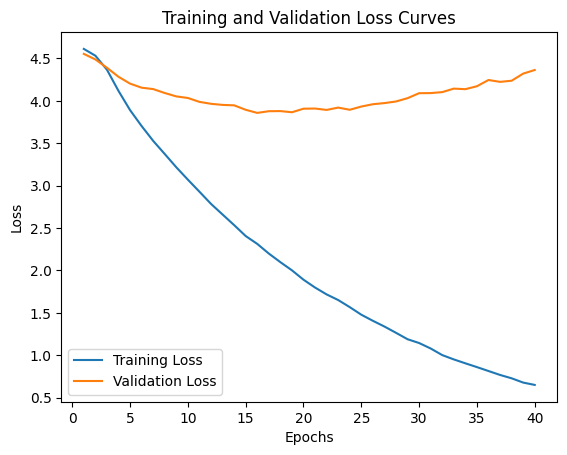

Final model saved to: /content/drive/MyDrive/transformer_asl_checkpoint_run_asl_run2.pt


In [5]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
from google.colab import drive

def plot_losses(train_losses: list, val_losses: list):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()


# Load pretrained 3D CNN
num_classes = len(class_names)
input_dim = 75 * 3 # xyz
target_frames = 64
model = Transformer(input_dim=input_dim, num_classes=num_classes, seq_len=target_frames)
model.to(device)

# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
EPOCHS = 40
start_epoch = 0
run = 2

# Load saved model from checkpoint
drive.mount('/content/drive')
CHECKPOINT_PATH = f"/content/drive/MyDrive/transformer_asl_checkpoint_run{run}.pt"
MODEL_PATH = f"/content/drive/MyDrive/transformer_asl_checkpoint_run_asl_run{run}.pt"
LABELS_PATH = f"/content/drive/MyDrive/transformer_asl_checkpoint_run_asl_labels_run{run}.json"

if os.path.exists(CHECKPOINT_PATH):
    print("Loading checkpoint")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    train_losses = checkpoint["train_losses"]
    val_losses = checkpoint["val_losses"]
    print(f"Resuming from epoch {start_epoch}")
else:
    train_losses, val_losses = [], []

# Training loop
for epoch in range(start_epoch, EPOCHS):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    # Initialize pbar here
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
        pbar.set_postfix(loss=loss.item(), acc=100.*correct/total)

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_epoch_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item()
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += preds.eq(labels).sum().item()
    val_losses.append(val_epoch_loss / len(val_loader))
    val_acc = 100. * val_correct / val_total

    print(f"Epoch {epoch+1}: Train Acc={100.*correct/total:.2f}% | Val Acc={val_acc:.2f}%")

    # Save checkpoint every epoch
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses
    }
    torch.save(checkpoint, CHECKPOINT_PATH)
    print(f"Checkpoint saved at epoch {epoch+1}")

plot_losses(train_losses, val_losses)
torch.save(model.state_dict(), MODEL_PATH)
with open(LABELS_PATH, "w") as f:
    json.dump(class_names, f)
print("Final model saved to:", MODEL_PATH)

Testing Model

In [ ]:
import cv2
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import tqdm
import os
import torch.nn as nn
from torchvision.models.video import r3d_18
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


IMG_SIZE = 112
BATCH_SIZE = 4
target_frames = 60
run = 0

# choose device
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU")
else:
    device = "cpu"
    print("Using CPU")

# Test dataset augmentations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
    #transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


# Test dataset that only uses words the model trained on
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, class_map=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = [] # stores (video_path, label_idx) tuples

        if class_map is None:
            self.class_to_idx = {}
            self.idx_to_class = []
            label_folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
            for i, label_name in enumerate(label_folders):
                self.class_to_idx[label_name] = i
                self.idx_to_class.append(label_name)
        else:
            self.class_to_idx = class_map['class_to_idx']
            self.idx_to_class = class_map['idx_to_class']

        # Populate samples and create class mappings
        for label_name in os.listdir(root_dir):
            if label_name in self.class_to_idx: # Only include labels present in the class_to_idx map
                label_path = os.path.join(root_dir, label_name)
                if os.path.isdir(label_path):
                    label_idx = self.class_to_idx[label_name]
                    for video_file in os.listdir(label_path):
                        if video_file.lower().endswith('.mp4'):
                            video_path = os.path.join(label_path, video_file)
                            self.samples.append((video_path, label_idx))

        self.class_names = self.idx_to_class
        print(f"Found {len(self.samples)} video samples across {len(set(label for _, label in self.samples))} classes in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = self._load_all_frames(video_path)

        # Apply transformations to each frame
        transformed_frames = []
        for frame in frames:
            pil_image = Image.fromarray(frame)
            if self.transform:
                transformed_frames.append(self.transform(pil_image))

        frames_tensor = torch.stack(transformed_frames) # Shape: (T, C, H, W)
        frames_tensor = frames_tensor.permute(1, 0, 2, 3) # Shape: (C, T, H, W)

        return frames_tensor, label

    def _load_all_frames(self, video_path):
      cap = cv2.VideoCapture(video_path)
      if not cap.isOpened():
          print(f"Error: Could not open video file: {video_path}")
          return []

      extracted_frames_rgb = []
      while True:
          ret, frame = cap.read()
          if not ret:
              break
          rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          extracted_frames_rgb.append(rgb_frame)

      cap.release()

      if len(extracted_frames_rgb) == 0:
          print(f"Warning: No frames extracted from video {video_path}")

      return extracted_frames_rgb


# Config
test_dir = f"/content/drive/MyDrive/WLASL/WLASL100_test_{target_frames}frames"
LABELS_PATH = f"/content/drive/MyDrive/3d_cnn_asl_labels_run{run}.json"
MODEL_PATH = f"/content/drive/MyDrive/3d_cnn_asl_checkpoint_run{run}.pt"


# Build labels list
with open(LABELS_PATH, "r") as f:
    class_names = json.load(f)
class_to_idx = {c: i for i, c in enumerate(class_names)}
num_classes = len(class_names)

train_labels = set(class_names)
test_labels = {d.name for d in Path(test_dir).iterdir() if d.is_dir()}
in_train_and_test = sorted(list(train_labels & test_labels))
print(f"Testing on {len(in_train_and_test)} shared classes between training & testing")

# Create class_map
test_class_map = {'class_to_idx': class_to_idx, 'idx_to_class': class_names}

# Initialize dataset, dataloader, and model
test_dataset = VideoDataset(test_dir, transform=transform, class_map=test_class_map)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = r3d_18(weights="KINETICS400_V1")
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

# Load model
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

# Testing
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute & display metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# cm = confusion_matrix(all_labels, all_preds)
# print("Confusion Matrix:")
# print(cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(xticks_rotation='vertical', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()

Testing Model

In [ ]:
import cv2
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import tqdm
import os
import torch.nn as nn
from torchvision.models.video import r3d_18
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


IMG_SIZE = 112
BATCH_SIZE = 4
target_frames = 60
run = 4

# choose device
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU")
else:
    device = "cpu"
    print("Using CPU")

# Test dataset augmentations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
    #transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


# Test dataset that only uses words the model trained on
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, class_map=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = [] # stores (video_path, label_idx) tuples

        if class_map is None:
            self.class_to_idx = {}
            self.idx_to_class = []
            label_folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
            for i, label_name in enumerate(label_folders):
                self.class_to_idx[label_name] = i
                self.idx_to_class.append(label_name)
        else:
            self.class_to_idx = class_map['class_to_idx']
            self.idx_to_class = class_map['idx_to_class']

        # Populate samples and create class mappings
        for label_name in os.listdir(root_dir):
            if label_name in self.class_to_idx: # Only include labels present in the class_to_idx map
                label_path = os.path.join(root_dir, label_name)
                if os.path.isdir(label_path):
                    label_idx = self.class_to_idx[label_name]
                    for video_file in os.listdir(label_path):
                        if video_file.lower().endswith('.mp4'):
                            video_path = os.path.join(label_path, video_file)
                            self.samples.append((video_path, label_idx))

        self.class_names = self.idx_to_class
        print(f"Found {len(self.samples)} video samples across {len(set(label for _, label in self.samples))} classes in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = self._load_all_frames(video_path)

        # Apply transformations to each frame
        transformed_frames = []
        for frame in frames:
            pil_image = Image.fromarray(frame)
            if self.transform:
                transformed_frames.append(self.transform(pil_image))

        frames_tensor = torch.stack(transformed_frames) # Shape: (T, C, H, W)
        frames_tensor = frames_tensor.permute(1, 0, 2, 3) # Shape: (C, T, H, W)

        return frames_tensor, label

    def _load_all_frames(self, video_path):
      cap = cv2.VideoCapture(video_path)
      if not cap.isOpened():
          print(f"Error: Could not open video file: {video_path}")
          return []

      extracted_frames_rgb = []
      while True:
          ret, frame = cap.read()
          if not ret:
              break
          rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          extracted_frames_rgb.append(rgb_frame)

      cap.release()

      if len(extracted_frames_rgb) == 0:
          print(f"Warning: No frames extracted from video {video_path}")

      return extracted_frames_rgb


# Config
test_dir = f"/content/drive/MyDrive/WLASL/WLASL100_test_{target_frames}frames"
LABELS_PATH = f"/content/drive/MyDrive/3d_cnn_asl_labels_run{run}.json"
MODEL_PATH = f"/content/drive/MyDrive/3d_cnn_asl_checkpoint_run{run}.pt"


# Build labels list
with open(LABELS_PATH, "r") as f:
    class_names = json.load(f)
class_to_idx = {c: i for i, c in enumerate(class_names)}
num_classes = len(class_names)

train_labels = set(class_names)
test_labels = {d.name for d in Path(test_dir).iterdir() if d.is_dir()}
in_train_and_test = sorted(list(train_labels & test_labels))
print(f"Testing on {len(in_train_and_test)} shared classes between training & testing")

# Create class_map
test_class_map = {'class_to_idx': class_to_idx, 'idx_to_class': class_names}

# Initialize dataset, dataloader, and model
test_dataset = VideoDataset(test_dir, transform=transform, class_map=test_class_map)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = r3d_18(weights="KINETICS400_V1")
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

# Load model
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

# Testing
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute & display metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# cm = confusion_matrix(all_labels, all_preds)
# print("Confusion Matrix:")
# print(cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(xticks_rotation='vertical', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()